In [40]:
#  Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [41]:
#  Load the dataset
data = pd.read_csv(r"D:\kaggle\train_dataset.csv", index_col=0)
eval = pd.read_csv(r"D:\kaggle\eval_dataset.csv", index_col=0)

In [42]:
# Basic Data Overview
print(data.head())
print(data.info())

     Age  Gender  Reviews_Read    Price  Discount  Category  Items_In_Cart  \
id                                                                           
0   20.0     1.0           1.0  623.797      25.0       4.0            4.0   
1   22.0     0.0           5.0  549.324      50.0       4.0            8.0   
2   18.0     0.0           2.0  489.191      19.0       0.0            5.0   
3   25.0     0.0           3.0  769.450      16.0       4.0            5.0   
4   22.0     1.0           2.0   39.308      35.0       0.0            3.0   

   Time_of_Day  Email_Interaction Device_Type Payment_Method Referral_Source  \
id                                                                             
0    afternoon                0.0     Desktop         PayPal          Direct   
1      evening                0.0     Desktop           Bank   Search_engine   
2    afternoon                0.0      Mobile           Bank           Email   
3      evening                0.0      Mobile        

## Exploratory Data Analysis

In [43]:
# Handle missing values (if any)
# Checking for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Age                            970
Gender                         141
Reviews_Read                   127
Price                          145
Discount                       124
Category                       134
Items_In_Cart                  141
Time_of_Day                    129
Email_Interaction              127
Device_Type                    124
Payment_Method                1009
Referral_Source                997
Socioeconomic_Status_Score     120
Engagement_Score               135
Purchase                         0
dtype: int64


In [44]:
# Checking for eval_dataset missing values
print("Missing values:\n", eval.isnull().sum())

Missing values:
 Age                           530
Gender                         59
Reviews_Read                   73
Price                          55
Discount                       76
Category                       66
Items_In_Cart                  59
Time_of_Day                    71
Email_Interaction              73
Device_Type                    76
Payment_Method                491
Referral_Source               503
Socioeconomic_Status_Score     80
Engagement_Score               65
dtype: int64


In [45]:
# Check for duplicate data
print(data.duplicated().sum())
print(eval.duplicated().sum())

0
0


In [46]:
import pandas as pd

# Define categorical and numerical columns
categorical_cols = ['Gender', 'Category', 'Time_of_Day', 'Email_Interaction', 'Device_Type', 'Payment_Method', 'Referral_Source']
numerical_cols = ['Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart', 'Socioeconomic_Status_Score', 'Engagement_Score']

# Preprocessing function
def preprocess_data(dataset, categorical_cols, numerical_cols):
    # 1. Handle categorical variables
    # Identify original string columns
    original_string_cols = dataset.select_dtypes(include=['object']).columns.tolist()
    # Identify numerical columns that were converted to strings
    converted_string_cols = list(set(categorical_cols) - set(original_string_cols))

    # Standardize categorical variables
    for col in original_string_cols:
        dataset[col] = dataset[col].astype(str).str.lower().str.replace('0', 'o')

    for col in converted_string_cols:
        dataset[col] = dataset[col].astype(str)

    # Check and print the count of missing values in categorical variables (before replacement)
    print(f"Missing values in categorical variables (before replacement):\n{dataset[categorical_cols].isna().sum()}")

    # Replace implicit missing values with explicit pd.NA
    dataset[categorical_cols] = dataset[categorical_cols].replace(['', 'nan', 'N/A', '<NA>', 'None'], pd.NA)

    # Check and print the count of missing values in categorical variables (after replacement)
    print(f"Missing values in categorical variables (after replacement):\n{dataset[categorical_cols].isna().sum()}")

    return dataset

# Clean the two datasets
data = preprocess_data(data, categorical_cols, numerical_cols)
eval = preprocess_data(eval, categorical_cols, numerical_cols)

Missing values in categorical variables (before replacement):
Gender               0
Category             0
Time_of_Day          0
Email_Interaction    0
Device_Type          0
Payment_Method       0
Referral_Source      0
dtype: int64
Missing values in categorical variables (after replacement):
Gender                141
Category              134
Time_of_Day           129
Email_Interaction     127
Device_Type           124
Payment_Method       1009
Referral_Source       997
dtype: int64
Missing values in categorical variables (before replacement):
Gender               0
Category             0
Time_of_Day          0
Email_Interaction    0
Device_Type          0
Payment_Method       0
Referral_Source      0
dtype: int64
Missing values in categorical variables (after replacement):
Gender                59
Category              66
Time_of_Day           71
Email_Interaction     73
Device_Type           76
Payment_Method       491
Referral_Source      503
dtype: int64


In [47]:
import pandas as pd

# Define the preprocessing function
def preprocess_data(dataset, numerical_cols, categorical_cols, is_training=True):
    # 1. Fill missing values for numerical variables
    for col in numerical_cols:
        mean_value = dataset[col].mean()
        dataset[col] = dataset[col].fillna(mean_value)

    # 2. Fill missing values for categorical variables
    for col in categorical_cols:
        if col in ['Payment_Method', 'Referral_Source']:
            # Fill specific columns with 'unknown'
            dataset[col] = dataset[col].fillna('unknown')
        else:
            # Fill other categorical columns with the mode
            dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

    return dataset

# Preprocess the training dataset
data = preprocess_data(data, numerical_cols, categorical_cols, is_training=True)

# Preprocess the evaluation dataset
eval = preprocess_data(eval, numerical_cols, categorical_cols, is_training=False)

# 5. Perform one-hot encoding on categorical variables
data = pd.get_dummies(data, columns=categorical_cols, drop_first=False)
eval = pd.get_dummies(eval, columns=categorical_cols, drop_first=False)

# Check the structure of the datasets
print("Structure of the training dataset:\n", data.info())
print("\nStructure of the evaluation dataset:\n", eval.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            6500 non-null   float64
 1   Reviews_Read                   6500 non-null   float64
 2   Price                          6500 non-null   float64
 3   Discount                       6500 non-null   float64
 4   Items_In_Cart                  6500 non-null   float64
 5   Socioeconomic_Status_Score     6500 non-null   float64
 6   Engagement_Score               6500 non-null   float64
 7   Purchase                       6500 non-null   int64  
 8   Gender_0.0                     6500 non-null   bool   
 9   Gender_1.0                     6500 non-null   bool   
 10  Category_0.0                   6500 non-null   bool   
 11  Category_1.0                   6500 non-null   bool   
 12  Category_2.0                   6500 non-null   bool  

In [49]:
# Print the final feature list
final_feature_list = eval.columns.tolist()
print("\nFinal Feature List:", final_feature_list)


Final Feature List: ['Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart', 'Socioeconomic_Status_Score', 'Engagement_Score', 'Gender_0.0', 'Gender_1.0', 'Category_0.0', 'Category_1.0', 'Category_2.0', 'Category_3.0', 'Category_4.0', 'Time_of_Day_afternoon', 'Time_of_Day_evening', 'Time_of_Day_morning', 'Email_Interaction_0.0', 'Email_Interaction_1.0', 'Device_Type_desktop', 'Device_Type_mobile', 'Device_Type_tablet', 'Payment_Method_bank', 'Payment_Method_cash', 'Payment_Method_credit', 'Payment_Method_paypal', 'Payment_Method_unknown', 'Referral_Source_ads', 'Referral_Source_direct', 'Referral_Source_email', 'Referral_Source_search_engine', 'Referral_Source_social_media', 'Referral_Source_unknown']


In [50]:
# Step 1: Generate new features
for dataset in [data, eval]:
    dataset['Effective_Price'] = dataset['Price'] * (1 - dataset['Discount'] / 100)

# Add the new feature to the numerical columns
numerical_cols.append('Effective_Price')
final_feature_list.append('Effective_Price')

# Print the updated final feature list
print("Updated Final Feature List:", final_feature_list)


Updated Final Feature List: ['Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart', 'Socioeconomic_Status_Score', 'Engagement_Score', 'Gender_0.0', 'Gender_1.0', 'Category_0.0', 'Category_1.0', 'Category_2.0', 'Category_3.0', 'Category_4.0', 'Time_of_Day_afternoon', 'Time_of_Day_evening', 'Time_of_Day_morning', 'Email_Interaction_0.0', 'Email_Interaction_1.0', 'Device_Type_desktop', 'Device_Type_mobile', 'Device_Type_tablet', 'Payment_Method_bank', 'Payment_Method_cash', 'Payment_Method_credit', 'Payment_Method_paypal', 'Payment_Method_unknown', 'Referral_Source_ads', 'Referral_Source_direct', 'Referral_Source_email', 'Referral_Source_search_engine', 'Referral_Source_social_media', 'Referral_Source_unknown', 'Effective_Price']


In [51]:
# Checking for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Age                              0
Reviews_Read                     0
Price                            0
Discount                         0
Items_In_Cart                    0
Socioeconomic_Status_Score       0
Engagement_Score                 0
Purchase                         0
Gender_0.0                       0
Gender_1.0                       0
Category_0.0                     0
Category_1.0                     0
Category_2.0                     0
Category_3.0                     0
Category_4.0                     0
Time_of_Day_afternoon            0
Time_of_Day_evening              0
Time_of_Day_morning              0
Email_Interaction_0.0            0
Email_Interaction_1.0            0
Device_Type_desktop              0
Device_Type_mobile               0
Device_Type_tablet               0
Payment_Method_bank              0
Payment_Method_cash              0
Payment_Method_credit            0
Payment_Method_paypal            0
Payment_Method_unknown           0
Ref

In [52]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Standardize numerical variables in the training dataset
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Standardize numerical variables in the evaluation dataset (using the same scaler)
eval[numerical_cols] = scaler.transform(eval[numerical_cols])

# Check the results after standardization
print("Numerical variables in the training dataset after standardization:\n", data[numerical_cols].head())
print("\nNumerical variables in the evaluation dataset after standardization:\n", eval[numerical_cols].head())

Numerical variables in the training dataset after standardization:
          Age  Reviews_Read     Price  Discount  Items_In_Cart  \
id                                                              
0  -1.011846     -1.176996  0.423223  0.004929       0.167870   
1  -0.846814      1.130648  0.162018  1.762468       1.560092   
2  -1.176879     -0.600085 -0.048892 -0.416881       0.515926   
3  -0.599265     -0.023174  0.934084 -0.627786       0.515926   
4  -0.846814     -0.600085 -1.626803  0.707944      -0.180185   

    Socioeconomic_Status_Score  Engagement_Score  Effective_Price  
id                                                                 
0                     1.296648         -0.051821         0.392531  
1                     1.413043          0.881906        -0.448944  
2                    -1.156393         -0.104129         0.080643  
3                     0.627372          0.987935         1.169995  
4                    -0.818845          1.358504        -1.534020  


In [13]:
!pip install imbalanced-learn



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Case 1： SMOTE + New feature

In [53]:
from imblearn.over_sampling import SMOTE

# Define the feature variables X and the target variable y
X = data[final_feature_list]  # Retain only the final selected feature variables
y = data['Purchase']  # Extract the target variable


In [54]:
# Case 1 - Adjust data imbalance using SMOTE (oversampling)
# Define SMOTE
smote = SMOTE(random_state=42)

# Perform oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the distribution of classes after resampling
print("Class distribution after resampling:")
print(y_resampled.value_counts())

# Check the structure of the resampled data
print("\nResampled feature data dimensions:", X_resampled.shape)
print("\nResampled target variable dimensions:", y_resampled.shape)


Class distribution after resampling:
Purchase
0    5744
1    5744
Name: count, dtype: int64

Resampled feature data dimensions: (11488, 34)

Resampled target variable dimensions: (11488,)


In [55]:
# Case 1
# Train with oversampled data
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Check the split results
print(f"Number of samples in the training set: {X_train.shape[0]}")
print(f"Number of samples in the testing set: {X_test.shape[0]}")
print(f"Class distribution in the training set:\n{y_train.value_counts()}")
print(f"Class distribution in the testing set:\n{y_test.value_counts()}")

Number of samples in the training set: 9190
Number of samples in the testing set: 2298
Class distribution in the training set:
Purchase
1    4616
0    4574
Name: count, dtype: int64
Class distribution in the testing set:
Purchase
0    1170
1    1128
Name: count, dtype: int64


In [56]:
# Case 1
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the initial Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Evaluate the initial model's F1-score using 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-Validated F1-Score (Before Hyperparameter Tuning): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Train the model with initial parameters
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Print evaluation metrics for the initial model
print("\nInitial Model Evaluation:")
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate the ROC-AUC score
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Hyperparameter tuning: Grid Search with Cross-Validation
print("\nStarting Grid Search for Hyperparameter Tuning...")
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithms
    'penalty': ['l2'],  # Use L2 regularization
    'class_weight': ['balanced', None]  # Handle imbalanced data
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=5,  # 5-fold cross-validation
    verbose=1  # Display detailed search progress
)

# Perform grid search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)

# Retrain the model using the best parameters
best_log_reg = grid_search.best_estimator_
print("\nRetraining model with the best hyperparameters...")
best_log_reg.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_best_pred = best_log_reg.predict(X_test)

# Calculate the optimized F1-score
best_f1 = f1_score(y_test, y_best_pred)
print(f"\nOptimized F1-score: {best_f1:.4f}")

# Print the optimized confusion matrix and classification report
print("\nOptimized Confusion Matrix:")
print(confusion_matrix(y_test, y_best_pred))

print("\nOptimized Classification Report:")
print(classification_report(y_test, y_best_pred))

# Cross-validation evaluation for the optimized model
best_cv_scores = cross_val_score(best_log_reg, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-Validated F1-Score (After Hyperparameter Tuning): {best_cv_scores.mean():.4f} ± {best_cv_scores.std():.4f}")

# Calculate the ROC-AUC score for the optimized model
y_best_pred_proba = best_log_reg.predict_proba(X_test)[:, 1]
optimized_roc_auc = roc_auc_score(y_test, y_best_pred_proba)
print(f"Optimized ROC-AUC Score: {optimized_roc_auc:.4f}")


Cross-Validated F1-Score (Before Hyperparameter Tuning): 0.9280 ± 0.0044

Initial Model Evaluation:
F1-score: 0.9239

Confusion Matrix:
[[1145   25]
 [ 138  990]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1170
           1       0.98      0.88      0.92      1128

    accuracy                           0.93      2298
   macro avg       0.93      0.93      0.93      2298
weighted avg       0.93      0.93      0.93      2298

ROC-AUC Score: 0.9669

Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters from Grid Search:
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

Retraining model with the best hyperparameters...

Optimized F1-score: 0.9259

Optimized Confusion Matrix:
[[1153   17]
 [ 141  987]]

Optimized Classification Report:
              precision    recall  f1-score   support

           0       

In [57]:
# Case 1
# Step 1: Ensure the eval dataset contains the same features as the training data
eval_processed = eval[final_feature_list]

# Step 2: Make predictions using the trained model
eval_predictions = best_log_reg.predict(eval_processed)

# Step 3: Create a DataFrame for the prediction results
eval_results = pd.DataFrame({
    'id': eval.index,  # Assuming `id` is the index of the eval dataset
    'Purchase': eval_predictions  # Predicted classification results
})

# Save the results to a CSV file
eval_results.to_csv(r'D:\kaggle\result\logistical_case1add.csv', index=False)

print("Prediction file has been generated with columns: id, Purchase")
print(eval_results.head())  # View the first few rows of the generated prediction results


Prediction file has been generated with columns: id, Purchase
     id  Purchase
0  6500         0
1  6501         0
2  6502         0
3  6503         0
4  6504         0


In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature coefficients
coefficients = best_log_reg.coef_[0]  # Extract feature weights for the positive class

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': final_feature_list,
    'Coefficient': coefficients,
    'Absolute_Importance': np.abs(coefficients)  # Compute the absolute value of weights
})

# Sort by absolute importance to find the most significant features
feature_importance = feature_importance.sort_values(by='Absolute_Importance', ascending=False)

# Print the most important features
print("Top Features Affecting F1-score:")
print(feature_importance.head(10))



Top Features Affecting F1-score:
                          Feature  Coefficient  Absolute_Importance
30  Referral_Source_search_engine     5.481092             5.481092
32        Referral_Source_unknown     5.346034             5.346034
31   Referral_Source_social_media     5.331035             5.331035
29          Referral_Source_email     5.317371             5.317371
7                      Gender_0.0     5.279245             5.279245
27            Referral_Source_ads     5.232146             5.232146
28         Referral_Source_direct     5.134433             5.134433
20             Device_Type_mobile     5.119546             5.119546
18          Email_Interaction_1.0     5.046882             5.046882
26         Payment_Method_unknown     4.876157             4.876157


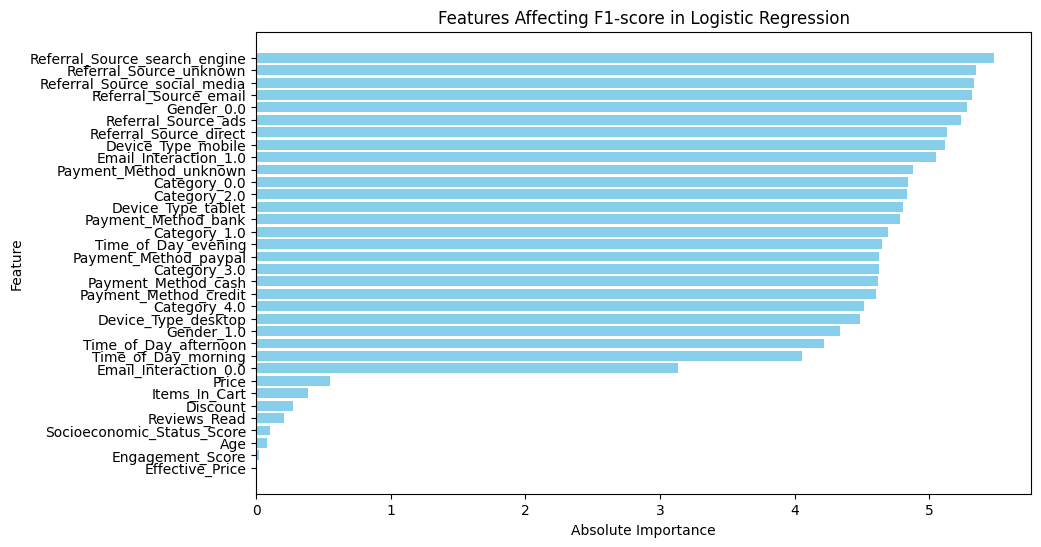

In [60]:
# Visualization of Feature Importance
import matplotlib.pyplot as plt

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute_Importance'], color='skyblue')
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.title('Features Affecting F1-score in Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to place the most important feature at the top
plt.show()


## Case 2： NO SMOTE + New feature

In [61]:
# Case 2 - Without SMOTE, using Logistic Regression's built-in balancing
# Define the feature variables X and the target variable y
X = data[final_feature_list]  # Retain only the final selected feature variables
y = data['Purchase']  # Extract the target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the initial Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Evaluate the initial model's F1-score using 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-Validated F1-Score (Before Hyperparameter Tuning): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Train the model with initial parameters
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Print evaluation metrics for the initial model
print("\nInitial Model Evaluation:")
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Hyperparameter tuning: Grid Search with Cross-Validation
print("\nStarting Grid Search for Hyperparameter Tuning...")
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithms
    'penalty': ['l2'],  # Use L2 regularization
    'class_weight': ['balanced', None]  # Handle imbalanced data
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=5,  # 5-fold cross-validation
    verbose=1  # Display detailed search progress
)

# Perform grid search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)

# Retrain the model using the best parameters
best_log_reg = grid_search.best_estimator_
print("\nRetraining model with the best hyperparameters...")
best_log_reg.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_best_pred = best_log_reg.predict(X_test)

# Calculate the optimized F1-score
best_f1 = f1_score(y_test, y_best_pred)
print(f"\nOptimized F1-score: {best_f1:.4f}")

# Print the optimized confusion matrix and classification report
print("\nOptimized Confusion Matrix:")
print(confusion_matrix(y_test, y_best_pred))

print("\nOptimized Classification Report:")
print(classification_report(y_test, y_best_pred))

# Cross-validation evaluation for the optimized model
best_cv_scores = cross_val_score(best_log_reg, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-Validated F1-Score (After Hyperparameter Tuning): {best_cv_scores.mean():.4f} ± {best_cv_scores.std():.4f}")

Cross-Validated F1-Score (Before Hyperparameter Tuning): 0.2317 ± 0.0126

Initial Model Evaluation:
F1-score: 0.2000

Confusion Matrix:
[[1129   14]
 [ 138   19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1143
           1       0.58      0.12      0.20       157

    accuracy                           0.88      1300
   macro avg       0.73      0.55      0.57      1300
weighted avg       0.85      0.88      0.85      1300


Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters from Grid Search:
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Retraining model with the best hyperparameters...

Optimized F1-score: 0.3525

Optimized Confusion Matrix:
[[814 329]
 [ 53 104]]

Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.71      0.

In [62]:
# Feature Importance Visualization

# Get feature weights
coefficients = best_log_reg.coef_[0]  # Get feature weights for the positive class

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': final_feature_list,
    'Coefficient': coefficients,
    'Absolute_Importance': np.abs(coefficients)  # Calculate the absolute value of weights
})

# Sort features by absolute importance to identify the most important ones
feature_importance = feature_importance.sort_values(by='Absolute_Importance', ascending=False)

# Print the top features
print("Top Features Affecting F1-score:")
print(feature_importance.head(10))


Top Features Affecting F1-score:
                  Feature  Coefficient  Absolute_Importance
17  Email_Interaction_0.0    -0.971972             0.971972
18  Email_Interaction_1.0     0.917381             0.917381
8              Gender_1.0    -0.537788             0.537788
7              Gender_0.0     0.483196             0.483196
2                   Price    -0.423486             0.423486
4           Items_In_Cart    -0.381994             0.381994
16    Time_of_Day_morning    -0.310170             0.310170
15    Time_of_Day_evening     0.269628             0.269628
19    Device_Type_desktop    -0.268976             0.268976
13           Category_4.0    -0.248038             0.248038


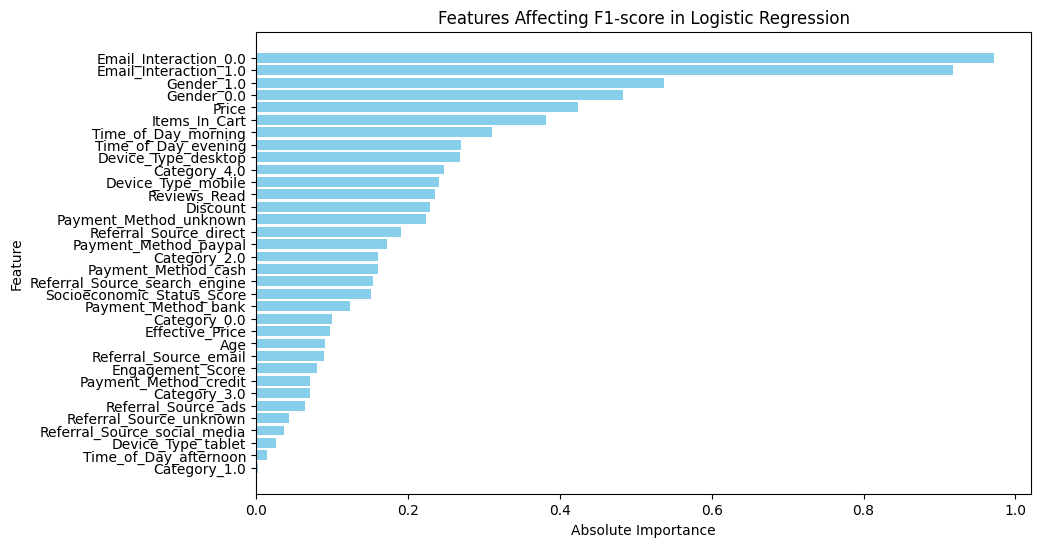

In [63]:
# Visualization
import matplotlib.pyplot as plt

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute_Importance'], color='skyblue')
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.title('Features Affecting F1-score in Logistic Regression')
plt.gca().invert_yaxis()  # Place the most important feature at the top
plt.show()


In [64]:
# Case 2
# Step 1: Ensure the eval dataset contains the same features as the training data
eval_processed = eval[final_feature_list]

# Step 2: Make predictions using the trained model
eval_predictions = best_log_reg.predict(eval_processed)

# Step 3: Create a DataFrame for the prediction results
eval_results = pd.DataFrame({
    'id': eval.index,  # Assuming `id` is the index of the eval dataset
    'Purchase': eval_predictions  # Predicted classification results
})

# Save the results to a CSV file
eval_results.to_csv(r'D:\kaggle\result\logistical_case2add.csv', index=False)

print("Prediction file has been generated with columns: id, Purchase")
print(eval_results.head())  # View the first few rows of the generated prediction results


Prediction file has been generated with columns: id, Purchase
     id  Purchase
0  6500         0
1  6501         0
2  6502         1
3  6503         0
4  6504         0
